# Predicting daily app installs

    We have daily data on an app's first-time installs from the AppStore. Our goal is to predict the number of installs over the course of 90 days. There are many factors that drive the number of installs for an App. Marketing efforts & word of mouth are amongst them.

## Importing Libraries

In [1]:
import pandas as pd
from darts import TimeSeries
import plotly
from darts.dataprocessing.transformers import Scaler
import matplotlib.pyplot as plt
from darts.metrics import mape
from darts.models import Prophet, RNNModel,NaiveDrift, TransformerModel

## Importing the Data

In [3]:
df = pd.read_csv('Data/ebay_de_ios.csv', delimiter=",").dropna()
series = TimeSeries.from_dataframe(df, 'Date', 'DE_installs')
train, val = series[:-365], series[-365:]

In [ ]:
df.head()

## Naive Benchmark
    This Naive prediction will be a benchmark for all subsequent model. We can assume that anything better than 15.83% MAPE is detected signal

Text(0.5, 1.0, 'MAPE: 15.83%')

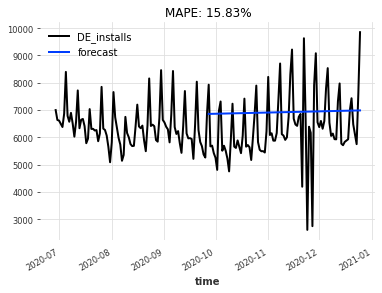

In [118]:
model = NaiveDrift()
model.fit(train)
prediction = model.predict(n=90)
series[-(365+90):-365+90].plot()
prediction.plot(label='forecast')
plt.legend()
plt.title("MAPE: {:.2f}%".format(mape(prediction, val[:90])))

## Facebook prophet
    Facebook prophet is a powerful model that is extremely easy to use 

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Text(0.5, 1.0, 'MAPE: 13.53%')

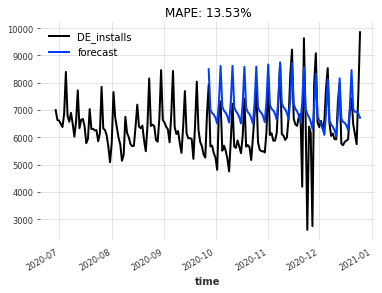

In [19]:
model = Prophet(yearly_seasonality=True,weekly_seasonality=True)
model.fit(train)
prediction = model.predict(n=90)
series[-(365+90):-365+90].plot()
prediction.plot(label='forecast')
plt.legend()
plt.title("MAPE: {:.2f}%".format(mape(prediction, val[:90])))

## LSTM Neural Network

[2022-01-31 16:24:13,837] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1233 samples.
[2022-01-31 16:24:13,837] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1233 samples.
INFO:darts.models.forecasting.torch_forecasting_model:Train dataset contains 1233 samples.
[2022-01-31 16:24:13,842] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-01-31 16:24:13,842] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
INFO:darts.models.forecasting.torch_forecasting_model:Time series values are 64-bits; casting model to float64.


  0%|          | 0/150 [00:00<?, ?it/s]

Text(0.5, 1.0, 'MAPE: 10.77%')

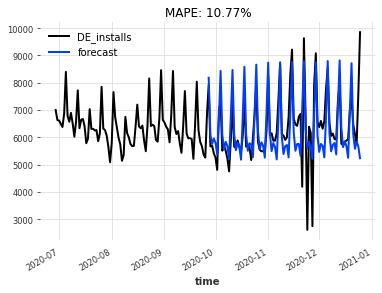

In [45]:
# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

model = RNNModel( model="LSTM",
    hidden_dim=30,
    dropout=0,
    batch_size=16,
    n_epochs=150,
    optimizer_kwargs={"lr": 4.9999e-3},
    model_name="Air_RNN",
    log_tensorboard=True,
    random_state=42,
    training_length=28,
    input_chunk_length=90,
    force_reset=True,
    save_checkpoints=True)

model.fit(
    train_transformed,
    verbose=True
)

prediction = model.predict(n=90)
series[-(365+90):-365+90].plot()
transformer.inverse_transform(prediction).plot(label='forecast')
plt.legend()

plt.title("MAPE: {:.2f}%".format(mape(transformer.inverse_transform(prediction), val[:90])))